In [1]:
from data_preprocessing import *
import matplotlib.pyplot as plt
import numpy as np

In [2]:
"""
Pre-Processing:

Splitting data into:
- regenerative and propulsive regimes by I_M (current) values
- blade angles: 15 and 30 deg
- AoA: steps of 2 between and including -12 and 12 deg
- J: between 0.55-1.50 for beta 15 deg
- J: between 0.90-2.10 for beta 30 deg

Final number of arrays is 52:
- 13 propulsive beta = 15 deg: alpha -12 to 12 deg, 0.55<=J<=1.50
- 13 propulsive beta = 30 deg: alpha -12 to 12 deg, 0.55<=J<=1.50
- 13 regen beta = 15 deg: alpha -12 to 12 deg, 0.90<=J<=2.10
- 13 regen beta = 30 deg: alpha -12 to 12 deg, 0.90<=J<=2.10
"""

# Retrieve Indices of Relevant Columns for Pre-Processing
column_headers = [
    'DPN', 'time', 'p_Atm', 'T_atm', 'rho_atm', 'mu_atm', 'gamma_atm', 'Qinf',
    'Vinf', 'AoA', 'beta', 'RPS_M', 'StdDevRPS', 'J', 'V_M', 'I_M', 'T_M',
    'PSus', 'PTus', 'FX_I', 'FY_I', 'FZ_I', 'MX_I', 'MY_I', 'MZ_I', 'FX_E',
    'FY_E', 'FZ_E', 'MX_E', 'MY_E', 'MZ_E'
]

V_index = column_headers.index('Vinf')
alpha_index = column_headers.index('AoA')
beta_index = column_headers.index('beta')
J_index = column_headers.index('J')
FZ_E_index = column_headers.index('FZ_E')
rho_index = column_headers.index('rho_atm')
n_index = column_headers.index('RPS_M')
Q_index = column_headers.index('MZ_E')

D = 0.4064  # diameter of propeller in m

# split into propulsive and regenerative regimes based on value of current, 'I_M'
data_propulsive, data_regen = filter_prop_regen(excel_path)

# split propulsive and regenerative regimes into 20, 30, 40, and other m/s
prop_18_22, prop_28_32, prop_38_42, prop_other = sort_Vinf(
    data_propulsive, V_index)
regen_18_22, regen_28_32, regen_38_42, regen_other = sort_Vinf(
    data_regen, V_index)

# sort based on alpha range -12 to 12
prop_V30 = sort_alpha_range(prop_28_32, alpha_index)
regen_V30 = sort_alpha_range(regen_28_32, alpha_index)

# sort based on beta
prop_V30_beta15, prop_V30_beta30 = sort_beta(prop_V30, beta_index)
regen_V30_beta15, regen_V30_beta30 = sort_beta(regen_V30, beta_index)

# sort based on J as specified per beta in reader
prop_V30_beta15 = sort_J(prop_V30_beta15, J_index, 0.55, 1.50)
prop_V30_beta30 = sort_J(prop_V30_beta30, J_index, 0.90, 2.10)
regen_V30_beta15 = sort_J(regen_V30_beta15, J_index, 0.55, 1.50)
regen_V30_beta30 = sort_J(regen_V30_beta30, J_index, 0.90, 2.10)

# problem because we don't get the full range of J for each regime
print(min(prop_V30_beta15[:, J_index]), '<= J prop V30 beta 15 <=',
      max(prop_V30_beta15[:, J_index]))
print(min(prop_V30_beta30[:, J_index]), '<= J prop V30 beta 30 <=',
      max(prop_V30_beta30[:, J_index]))
print(min(regen_V30_beta15[:, J_index]), '<= J regen V30 beta 15 <=',
      max(regen_V30_beta15[:, J_index]))
print(min(regen_V30_beta30[:, J_index]), '<= J regen V30 beta 30 <=',
      max(regen_V30_beta30[:, J_index]))

0.54959850465058 <= J prop V30 beta 15 <= 0.80140815880632
0.9056226306014 <= J prop V30 beta 30 <= 1.4937003851442
0.88191007530343 <= J regen V30 beta 15 <= 1.4861715935361
1.4356927111924 <= J regen V30 beta 30 <= 2.0873421668885


In [3]:
# for each operational condition where V, beta, and prop/regen are constant, sort into bins of J
J_arrays_prop_V30_beta15 = sort_J_bin(prop_V30_beta15, J_index)    
J_arrays_prop_V30_beta30 = sort_J_bin(prop_V30_beta30, J_index)
J_arrays_regen_V30_beta15 = sort_J_bin(regen_V30_beta15, J_index)
J_arrays_regen_V30_beta30 = sort_J_bin(regen_V30_beta30, J_index)   


In [4]:
# remove empty J bins arrays
J_arrays_prop_V30_beta15 = [arr for arr in J_arrays_prop_V30_beta15 if arr.shape[0] > 1]
constant=10
J_arrays_prop_V30_beta30 = [arr for arr in J_arrays_prop_V30_beta30 if arr.shape[0] > 1]
constant=10
J_arrays_regen_V30_beta15 = [arr for arr in J_arrays_regen_V30_beta15 if arr.shape[0] > 1]
constant=10
J_arrays_regen_V30_beta30 = [arr for arr in J_arrays_regen_V30_beta30 if arr.shape[0] > 1]
constant=10



In [19]:
#Define the thrust coefficent
def thrust_coeff(T, rho, n, D):
  C_T = -T / (rho * n**2 * D**4)
  return C_T


#DEFINE the power coefficient
def power_coeff(Q, rho, n, D):
  C_P = Q * 2 * np.pi / (rho* n**2 * D**5)
  return C_P

def efficiency(C_T, J, C_P):
    propulsive_eff = (C_T*J)/(2*np.pi*C_P)
    return propulsive_eff



In [20]:
# calculate C_T, C_P, eff and add to each array
for J_array in range(len(J_arrays_prop_V30_beta15)):
    # calculate C_T using def thrust_coeff(T, rho, n, D) and add C_T column to J_array
    C_T = thrust_coeff(J_arrays_prop_V30_beta15[J_array][:, FZ_E_index], J_arrays_prop_V30_beta15[J_array][:, rho_index], J_arrays_prop_V30_beta15[J_array][:, n_index], D)
    C_P = power_coeff(J_arrays_prop_V30_beta15[J_array][:, Q_index], J_arrays_prop_V30_beta15[J_array][:, rho_index], J_arrays_prop_V30_beta15[J_array][:, n_index], D)
    efficiencies = efficiency(C_T, J_arrays_prop_V30_beta15[J_array][:, J_index], C_P)
    efficiencies = np.clip(efficiencies, -0.25, 0.25) # limit efficiencies to be between -1 and 1
    J_arrays_prop_V30_beta15[J_array] = np.column_stack((J_arrays_prop_V30_beta15[J_array], C_T))
    J_arrays_prop_V30_beta15[J_array] = np.column_stack((J_arrays_prop_V30_beta15[J_array], C_P))
    J_arrays_prop_V30_beta15[J_array] = np.column_stack((J_arrays_prop_V30_beta15[J_array], efficiencies))

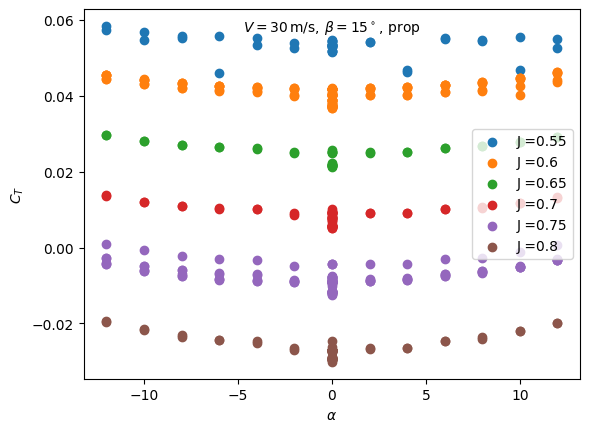

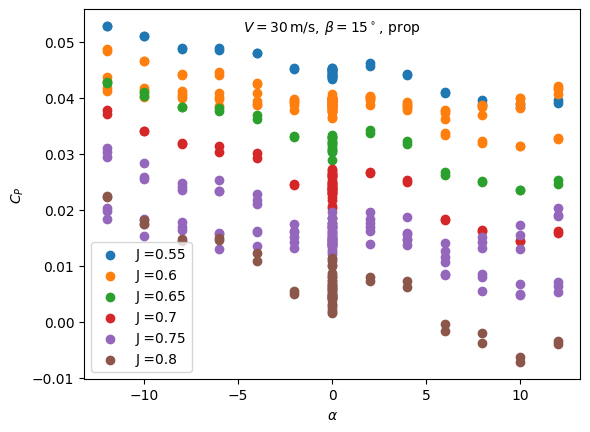

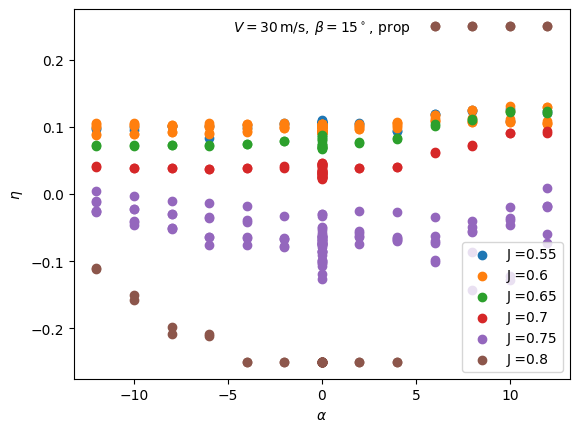

In [21]:
# plot C_T vs alpha for each J
fig, ax = plt.subplots()
for i in range(len(J_arrays_prop_V30_beta15)):
    J_label = str(round(round(J_arrays_prop_V30_beta15[i][:, J_index][0] / 0.05) * 0.05, 2))
    plt.scatter(J_arrays_prop_V30_beta15[i][:, alpha_index], J_arrays_prop_V30_beta15[i][:, -3], label  = 'J =' + J_label)

plt.xlabel(r'$\alpha$')
plt.ylabel(r'$C_T$')
plt.text(0.5, 0.95, r'$V = 30 \, \mathrm{m/s}, \, \beta = 15^\circ, \, \mathrm{prop}$', transform=ax.transAxes, horizontalalignment='center', verticalalignment='center')
plt.legend()
# save plot as png file and name according to J_arrays_prop_V30_beta15
plt.savefig('plots/C_T vs alpha for each J prop V30 beta 15.png')


# plot C_P vs alpha for each J
fig, ax = plt.subplots()
for i in range(len(J_arrays_prop_V30_beta15)):
    J_label = str(round(round(J_arrays_prop_V30_beta15[i][:, J_index][0] / 0.05) * 0.05, 2))
    plt.scatter(J_arrays_prop_V30_beta15[i][:, alpha_index], J_arrays_prop_V30_beta15[i][:, -2], label  = 'J =' + J_label)

plt.xlabel(r'$\alpha$')
plt.ylabel(r'$C_P$')
plt.text(0.5, 0.95, r'$V = 30 \, \mathrm{m/s}, \, \beta = 15^\circ, \, \mathrm{prop}$', transform=ax.transAxes, horizontalalignment='center', verticalalignment='center')
plt.legend()
# save plot as png file and name according to J_arrays_prop_V30_beta15
plt.savefig('plots/C_P vs alpha for each J prop V30 beta 15.png')


# plot eff vs alpha for each J
fig, ax = plt.subplots()
for i in range(len(J_arrays_prop_V30_beta15)):
    J_label = str(round(round(J_arrays_prop_V30_beta15[i][:, J_index][0] / 0.05) * 0.05, 2))
    plt.scatter(J_arrays_prop_V30_beta15[i][:, alpha_index], J_arrays_prop_V30_beta15[i][:, -1], label  = 'J =' + J_label)

plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\eta$')
plt.text(0.5, 0.95, r'$V = 30 \, \mathrm{m/s}, \, \beta = 15^\circ, \, \mathrm{prop}$', transform=ax.transAxes, horizontalalignment='center', verticalalignment='center')
plt.legend()
# save plot as png file and name according to J_arrays_prop_V30_beta15
plt.savefig('plots/eff vs alpha for each J prop V30 beta 15.png')